In [1]:
import pandas as pd
import zipfile, os
import numpy as np
import csv
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Specify the path to your CSV file
!wget https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv

df_beras = pd.read_csv('Beras.csv')
df_beras

--2024-06-11 19:23:27--  https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42658 (42K) [text/plain]
Saving to: ‘Beras.csv’

Beras.csv           100%[===================>]  41.66K  --.-KB/s    in 0.008s  

2024-06-11 19:23:28 (5.37 MB/s) - ‘Beras.csv’ saved [42658/42658]



,Tanggal,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Harga Beras Penggilingan,Produksi Beras,Harga Beras,UMP,BBM Solar,Tingkat Konsumsi
0,2021-03-15,10,4000,4150,5050,9465,14419,11200,4960,9600,17161
1,2021-03-16,10,3850,4100,4740,9360,14419,11200,4960,9600,17161
2,2021-03-17,10,4160,4230,4950,9400,14419,11200,4960,9600,17161
3,2021-03-18,10,4120,4190,4730,9340,14419,11200,4960,9600,17161
4,2021-03-19,10,4190,4290,4990,9410,14419,11200,4960,9600,17161
...,...,...,...,...,...,...,...,...,...,...,...
673,2023-12-21,30,6770,6850,7980,13100,14391,14000,5444,6800,17598
674,2023-12-22,30,6600,6760,8050,13095,14391,14000,5444,6800,17598
675,2023-12-27,30,6620,6760,8030,13120,14391,14000,5444,6800,17598
676,2023-12-28,30,6650,6760,8020,13120,14391,14000,5444,6800,17598


In [3]:
df_beras.drop(['Tanggal'], axis = 1, inplace = True)

In [4]:
df_beras_trend = pd.DataFrame()
df_beras_seasonal = pd.DataFrame()
df_beras_resid = pd.DataFrame()

for series_name, series in df_beras.items():
  stl = STL(df_beras[series_name], period=12, robust=True)
  result = stl.fit()
  df_beras_trend[series_name] = result.trend
  df_beras_seasonal[series_name] = result.seasonal
  df_beras_resid[series_name] = result.resid

In [5]:
# def data_to_X_y(df):
#   X = df.drop('Harga Beras', axis=1)
#   y = df['Harga Beras']

#   return X, y

def data_to_X_y(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][6]
    y.append(label)
  return np.array(X), np.array(y)

X_trend, y_trend = data_to_X_y(df_beras_trend)
X_seasonal, y_seasonal = data_to_X_y(df_beras_seasonal)
X_resid, y_resid = data_to_X_y(df_beras_resid)
X_trend.shape

(672, 6, 10)

In [6]:
def splitting_data(df, X, y):
  cutoff_index = int(len(df) * 0.8)

  # Split the dataset into training and testing sets using the calculated index
  X_train = X[:cutoff_index]
  X_test = X[cutoff_index:]
  y_train = y[:cutoff_index]
  y_test = y[cutoff_index:]

  return X_train, X_test, y_train, y_test

X_train_trend, X_test_trend, y_train_trend, y_test_trend = splitting_data(df_beras_trend, X_trend, y_trend)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = splitting_data(df_beras_seasonal, X_seasonal, y_seasonal)
X_train_resid, X_test_resid, y_train_resid, y_test_resid = splitting_data(df_beras_resid, X_resid, y_resid)

X_train_trend.shape

(542, 6, 10)

In [7]:
from sklearn.preprocessing import MinMaxScaler
trend_scaler = MinMaxScaler(feature_range=(-1,1))
seasonal_scaler = MinMaxScaler(feature_range=(-1,1))
resid_scaler = MinMaxScaler(feature_range=(-1,1))
# X_trend_scaler = MinMaxScaler(feature_range=(-1,1))
# y_trend_scaler = MinMaxScaler(feature_range=(-1,1))
# X_seasonal_scaler = MinMaxScaler(feature_range=(-1,1))
# y_seasonal_scaler = MinMaxScaler(feature_range=(-1,1))
# X_resid_scaler = MinMaxScaler(feature_range=(-1,1))
# y_resid_scaler = MinMaxScaler(feature_range=(-1,1))

def scaling_data(scaler, X_train, X_test, y_train, y_test):
  X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
  X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1))

  y_train = scaler.fit_transform(y_train.reshape(-1,1))
  y_test = scaler.transform(y_test.reshape(-1,1))

  return X_train, X_test, y_train, y_test

# def X_scaling_data(scaler, X_train, X_test):
#   X_train = scaler.fit_transform(np.array(X_train).reshape(X_train.shape[0], -1))
#   X_test = scaler.transform(np.array(X_test).reshape(X_test.shape[0], -1))
#   return X_train, X_test

# def y_scaling_data(scaler, y_train, y_test):
#   y_train = scaler.fit_transform(np.array(y_train).reshape(-1,1))
#   y_test = scaler.transform(np.array(y_test).reshape(-1,1))
#   return y_train, y_test

X_train_trend, X_test_trend, y_train_trend, y_test_trend = scaling_data(trend_scaler, X_train_trend, X_test_trend, y_train_trend, y_test_trend)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = scaling_data(seasonal_scaler, X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal)
X_train_resid, X_test_resid, y_train_resid, y_test_resid = scaling_data(resid_scaler, X_train_resid, X_test_resid, y_train_resid, y_test_resid)
# X_train_trend, X_test_trend = X_scaling_data(X_trend_scaler, X_train_trend, X_test_trend)
# y_train_trend, y_test_trend = y_scaling_data(y_trend_scaler, y_train_trend, y_test_trend)
# X_train_seasonal, X_test_seasonal = X_scaling_data(X_seasonal_scaler, X_train_seasonal, X_test_seasonal)
# y_train_seasonal, y_test_seasonal = y_scaling_data(y_seasonal_scaler, y_train_seasonal, y_test_seasonal)
# X_train_resid, X_test_resid = X_scaling_data(X_resid_scaler, X_train_resid, X_test_resid)
# y_train_resid, y_test_resid = y_scaling_data(y_resid_scaler, y_train_resid, y_test_resid)

In [8]:

def modelling_data(X_train, y_train):
  gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
  gbm.fit(X_train, y_train)

  return gbm

model_trend = modelling_data(X_train_trend, y_train_trend)
model_seasonal = modelling_data(X_train_seasonal, y_train_seasonal)
model_resid = modelling_data(X_train_resid, y_train_resid)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


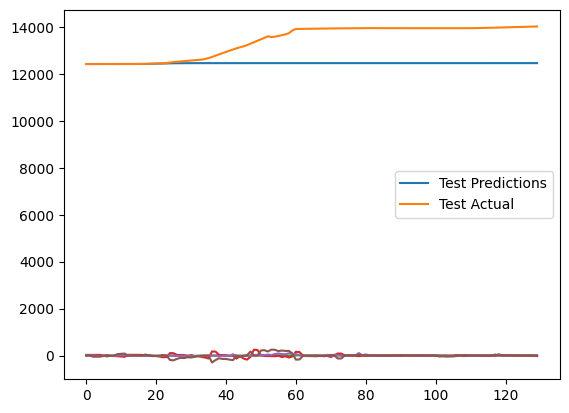

In [9]:
def predicting_data(scaler, lin_model, X_test, y_test):
  lin_pred=lin_model.predict(X_test)
  lin_pred_inv = scaler.inverse_transform(lin_pred.reshape(-1,1))

  plt.plot(lin_pred_inv)
  plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
  plt.legend(['Test Predictions', 'Test Actual'])

  # plt.rcParams["figure.figsize"] = (11,6)
  # # lin_pred_inv = scaler.inverse_transform(lin_pred.reshape(-1,1))
  # plt.plot(lin_pred,label='Linear_Regression_Predictions')
  # plt.plot(y_test,label='Actual Sales')
  # plt.legend(loc="upper left")
  # plt.show()

  return lin_pred_inv

predict_trend = predicting_data(trend_scaler, model_trend, X_test_trend, y_test_trend)
predict_seasonal = predicting_data(seasonal_scaler, model_seasonal, X_test_seasonal, y_test_seasonal)
predict_resid = predicting_data(resid_scaler, model_resid, X_test_resid, y_test_resid)

In [10]:
data_predict_jumlah = predict_trend + predict_seasonal + predict_resid
data_predict_jumlah

array([[12430.64452776],
       [12427.12686208],
       [12447.70356322],
       [12416.31478421],
       [12395.86494957],
       [12390.19341324],
       [12416.51771929],
       [12395.98093508],
       [12399.78538791],
       [12407.02727536],
       [12413.91952192],
       [12425.50582896],
       [12429.42496957],
       [12427.32420276],
       [12432.48189644],
       [12430.19693941],
       [12405.46482372],
       [12407.90441203],
       [12417.17583485],
       [12421.40542787],
       [12421.58514545],
       [12412.29547892],
       [12433.00016005],
       [12439.66089477],
       [12452.28910101],
       [12436.15125042],
       [12447.49957988],
       [12452.87325198],
       [12441.60883899],
       [12423.15712987],
       [12433.22163069],
       [12428.44612789],
       [12424.49641985],
       [12431.75562745],
       [12443.01336378],
       [12438.0589617 ],
       [12457.35925433],
       [12445.71829379],
       [12449.61361519],
       [12461.57565017],


In [11]:
y_test_trend_scaler_inverse = trend_scaler.inverse_transform(y_test_trend.reshape(-1,1))
y_test_seasonal_scaler_inverse = seasonal_scaler.inverse_transform(y_test_seasonal.reshape(-1,1))
y_test_resid_scaler_inverse = resid_scaler.inverse_transform(y_test_resid.reshape(-1,1))
y_test_asli = y_test_trend_scaler_inverse + y_test_seasonal_scaler_inverse + y_test_resid_scaler_inverse
y_test_asli

array([[12450.],
       [12450.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12450.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12400.],
       [12450.],
       [12450.],
       [12450.],
       [12500.],
       [12500.],
       [12550.],
       [12550.],
       [12550.],
       [12550.],
       [12600.],
       [12750.],
       [12750.],
       [12750.],
       [12800.],
       [12800.],
       [12850.],
       [12950.],
       [13050.],
       [13050.],
       [13050.],
       [13400.],
       [13600.],
       [13650.],
       [13700.],
       [13750.],
       [13750.],
       [13800.],
       [13800.],
       [13800.],
       [13800.],
       [13850.],
       [13850.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(data_predict_jumlah,y_test_asli))
mae = mean_absolute_error(data_predict_jumlah,y_test_asli)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(data_predict_jumlah,y_test_asli)

# Mean Magnitude of Relative Error
mmre = (abs((data_predict_jumlah - y_test_asli) / y_test_asli)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((data_predict_jumlah - y_test_asli) / y_test_asli))

# Mean Magnitude of Error Relative
mmer = (abs(data_predict_jumlah - y_test_asli)).mean()

# Mean Square Error
mse = mean_squared_error(data_predict_jumlah, y_test_asli)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 1165.0746333029228
Mean Absolute Error: 967.4230343065719
R Square: -1420.6680
Mean Magnitude of Relative Error: 0.0698
Median Magnitude of Relative Error: 0.1030
Mean Magnitude of Error Relative:  967.4230343065719
Mean Square Error: 1357398.90116594
